In [1]:
import os 
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import plot_model
# import GroupNormalization
from tensorflow_addons.layers import GroupNormalization

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "6"

In [3]:
model_path = "/home/abharadwaj1/dev/map_sharpening/emmernet/emmernet_training/hybrid_model_map_target/outputdata/augmented_dataset_dropout_bs_2_hybrid_modelmap_lr0001_200k/saved_models/hybrid_model_map_target_final_epoch_30.hdf5"
model = load_model(model_path, custom_objects={'GroupNormalization': GroupNormalization})

In [4]:
from locscale.include.emmer.ndimage.map_utils import save_as_mrc, load_map, resample_map
from locscale.emmernet.run_emmernet import preprocess_map
import os 
input_dir = "/home/abharadwaj1/papers/elife_paper/figure_information/data/emmernet_cubes_sensitivity_test/emd_0193/translation_sensitivity"
output_dir = os.path.join(input_dir, "output")
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

emmap_path = os.path.join(input_dir, "EMD_193_unsharpened_fullmap.mrc")
reference_emmap_path = os.path.join(input_dir, "emd_0193_hybrid_model_map_refined.mrc")
emmap, apix = load_map(emmap_path)
emmap_resampled = preprocess_map(emmap, apix)
reference_emmap, apix = load_map(reference_emmap_path)
reference_emmap_resampled = resample_map(reference_emmap, apix=apix, apix_new=1, order=2)


In [5]:
import matplotlib.pyplot as plt

def show_cube(cube, slice_index=16):
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].imshow(cube[:, :, slice_index], cmap="gray")
    ax[1].imshow(cube[:, slice_index, :], cmap="gray")
    ax[2].imshow(cube[slice_index, :, :], cmap="gray")
    plt.show()



(32, 32, 32)


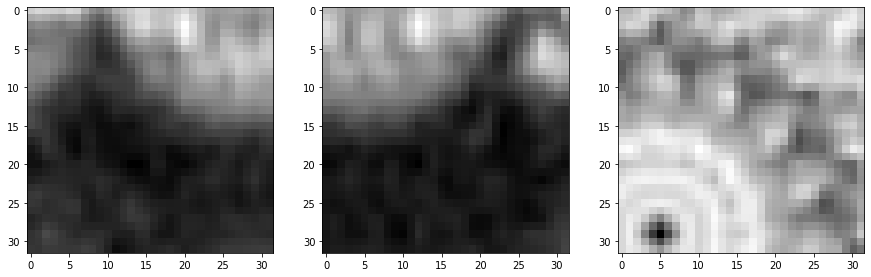

Center of the cube:  (256, 192, 216)


In [8]:
from locscale.include.emmer.ndimage.map_utils import extract_window
#center_test = (256, 240, 206)
z_constant = 256
x_constant = 216
y_index = 192
center_test = (z_constant, y_index, x_constant)
cube_test = extract_window(emmap_resampled, center_test, 32)
print(cube_test.shape)
show_cube(cube_test)
print("Center of the cube: ", center_test)


In [9]:
empty_map = np.zeros_like(emmap_resampled)
empty_map[center_test[0]-16:center_test[0]+16, center_test[1]-16:center_test[1]+16, center_test[2]-16:center_test[2]+16] = cube_test

test_cube_path = os.path.join(output_dir, "test_cube_z{}_y{}_x{}.mrc".format(center_test[0], center_test[1], center_test[2]))
resampled_empty_map = resample_map(empty_map, apix=1, apix_new=apix, order=2)
save_as_mrc(resampled_empty_map, test_cube_path, apix=apix)


In [10]:
def add_cube_to_empty_map(cube, center, reference_map, ref_apix, new_apix):
    resampled_reference_map = resample_map(reference_map, apix=ref_apix, apix_new=new_apix, order=2)
    empty_map = np.zeros_like(resampled_reference_map)
    empty_map[center[0]-16:center[0]+16, center[1]-16:center[1]+16, center[2]-16:center[2]+16] = cube
    resampled_empty_map = resample_map(empty_map, apix=new_apix, apix_new=ref_apix, order=2)
    return resampled_empty_map

In [11]:
# run a sensitivity analysis on the cube_test 
from scipy.ndimage import rotate
from tqdm import tqdm
y_indices = np.arange(160, 240, 2)
print(y_indices)
# axis of rotation is the z axis
# plane of rotation is the xy plane
translated_cubes = {}
translated_reference_cubes = {}
translated_cubes_dir = os.path.join(output_dir, "translated_cubes")
if not os.path.exists(translated_cubes_dir):
    os.makedirs(translated_cubes_dir)
for y_index in tqdm(y_indices):
    center_test = (z_constant, y_index, x_constant)
    translated_cube = extract_window(emmap_resampled, center_test, 32)
    translated_cubes[y_index] = translated_cube
    translated_reference_cube = extract_window(reference_emmap_resampled, (256, y_index, 206), 32)
    translated_reference_cubes[y_index] = translated_reference_cube
    #rotated_cube_map = add_cube_to_empty_map(rotated_cube, center_test, emmap, apix, 1)
    save_as_mrc(translated_cube, os.path.join(translated_cubes_dir, "translated_cube_z{}_y{}_x{}.mrc".format(center_test[0], center_test[1], center_test[2])), apix=1) 
    save_as_mrc(translated_reference_cube, os.path.join(translated_cubes_dir, "translated_reference_cube_z{}_y{}_x{}.mrc".format(center_test[0], center_test[1], center_test[2])), apix=1)
    



[160 162 164 166 168 170 172 174 176 178 180 182 184 186 188 190 192 194
 196 198 200 202 204 206 208 210 212 214 216 218 220 222 224 226 228 230
 232 234 236 238]


100%|██████████| 40/40 [00:00<00:00, 135.58it/s]


In [12]:
predicted_cubes = {}
for y_index in tqdm(y_indices):
    translated_cube = translated_cubes[y_index]
    translated_cube = np.expand_dims(translated_cube, axis=0)
    translated_cube = np.expand_dims(translated_cube, axis=-1)
    predicted_cube = model.predict(translated_cube)
    predicted_cubes[y_index] = np.squeeze(predicted_cube)
    

100%|██████████| 40/40 [00:07<00:00,  5.26it/s]


In [13]:
predicted_cubes_dir = os.path.join(output_dir, "predicted_cubes")
if not os.path.exists(predicted_cubes_dir):
    os.makedirs(predicted_cubes_dir)
for y_index in tqdm(y_indices):
    save_as_mrc(predicted_cubes[y_index], os.path.join(predicted_cubes_dir, "predicted_cube_z{}_y{}_x{}.mrc".format(center_test[0], y_index, center_test[2])), apix=1)
    
    
    

100%|██████████| 40/40 [00:00<00:00, 417.41it/s]


100%|██████████| 40/40 [00:00<00:00, 1261.15it/s]


Text(0.5, 1.0, 'RSC vs Y index')

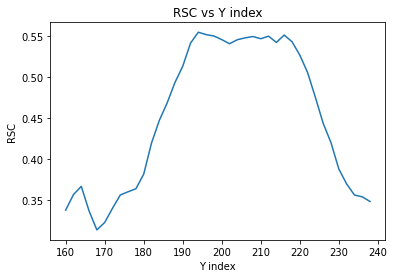

In [14]:
from locscale.include.emmer.ndimage.map_tools import compute_real_space_correlation as rsc 

rsc_y_indices = {}
for y_index in tqdm(y_indices):
    reference_cube = translated_reference_cubes[y_index]
    predicted_cube = predicted_cubes[y_index]
    rsc_angle = rsc(reference_cube, predicted_cube)
    rsc_y_indices[y_index] = rsc_angle

plt.plot(rsc_y_indices.keys(), rsc_y_indices.values())
plt.xlabel("Y index")
plt.ylabel("RSC")
plt.title("RSC vs Y index")



In [15]:
model_path_nodropout = "/home/abharadwaj1/dev/map_sharpening/emmernet/emmernet_training/hybrid_model_map_target/outputdata/no_augmentation_model_map_cube_32_bs_2/saved_models/hybrid_model_map_target_final_epoch_15.hdf5"
model_nodropout = load_model(model_path_nodropout, custom_objects={'GroupNormalization': GroupNormalization})

In [16]:
predicted_cubes_nodropout = {}
for y_index in y_indices:
    translated_cube = translated_cubes[y_index]
    translated_cube = np.expand_dims(translated_cube, axis=0)
    translated_cube = np.expand_dims(translated_cube, axis=-1)
    predicted_cube = model_nodropout.predict(translated_cube)
    predicted_cubes_nodropout[y_index] = np.squeeze(predicted_cube)
    

In [17]:
rscc_y_indices_nodropout = {}
for y_index in tqdm(y_indices):
    reference_cube = translated_reference_cubes[y_index]
    predicted_cube = predicted_cubes_nodropout[y_index]
    rscc_angle = rsc(reference_cube, predicted_cube)
    rscc_y_indices_nodropout[y_index] = rscc_angle
    


100%|██████████| 40/40 [00:00<00:00, 1020.63it/s]


Text(0.5, 1.0, 'RSC vs Y index (No Dropout)')

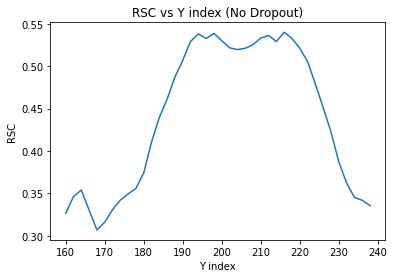

In [18]:
plt.plot(rscc_y_indices_nodropout.keys(), rscc_y_indices_nodropout.values())
plt.xlabel("Y index")
plt.ylabel("RSC")
plt.title("RSC vs Y index (No Dropout)")
